In [1]:
# !pip install arviz==0.6.1 -q
# !pip install pymc3==3.8 -q
# !pip install Theano==1.0.4 -q

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import IPython
import seaborn as sns
import arviz as az
import csv
import json
# import logging
# from google.colab import files

print('Running on Python v{}'.format(pm.__version__))
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on Python v3.8
Running on PyMC3 v3.8
Running on ArviZ v0.9.0


# Define plot functions

In [2]:
#@ def, Plot heatmaps subplots 
def plotHeatmaps(data,
                 rowTitles,
                 colTitles,
                 xLabel,
                 yLabel,
                 nRows,
                 nCols,
                 vmins,
                 vmaxs,
                 iRow):
    
    fig = plt.figure(figsize=[7,12])
    
    # im identifier:
    im = [None]*nCols
    x1, x2 = data[0] # Free parameters of the data.
    f = data[1] # Data that is the function of the free parameters.
    
    # Return the last row that is 'True' in 'plotWhat'. It sets in what row 
    # to show 'xlabel':
    max_plotWhat = np.max(np.where(plotWhat))
    
    levels = np.arange(0, 1.6, 0.1)
    # plot the nRows x nCols subplots with labels, titles at  
    # sceciefic locations. iCol is Column index, iRow is Row index:
    for iCol in range(nCols):
        fig.add_subplot(nRows, nCols, iRow*nCols + iCol+1)
        im[iCol] = plt.pcolor(x1 ,x2, f[iCol],
                              vmin=vmins[iCol], vmax=vmaxs[iCol],
                              shading='auto', cmap='Oranges')
            
        if True:  # iRow > 0:
            cs = plt.contour(x1 ,x2, f[iCol], levels, colors='k',
                              vmin=vmins[iCol], vmax=vmaxs[iCol])
            plt.clabel(cs, levels, inline=True, fmt='%.1f', fontsize=10)

        fig.colorbar(im[iCol])
        
        if iRow == 0:
            plt.title(colTitles[iCol] + rowTitles[iRow])
        
        else:
            plt.title(rowTitles[iRow])
        
        if iRow == max_plotWhat:
            plt.xlabel(xLabel)
            
        if iCol == 0:
            plt.ylabel(yLabel)
    
    fig.tight_layout()
    

In [3]:
DataToPlot = 4*[None]
plotWhat = [True,False,False,False]

def plotData(DataToPlot,plotWhat):
    # titles and labels:
    xLabel = "$DecayLength(nm)$"
    yLabel = "$Depletion(nm)$"

    Rg_ratio_Title = "$Rg ratio_{TCR*}^{TCRP}$\n"
    Phos_ratio_Title = "$Phos ratio_{TCR*}^{TCRP}$\n"
    colTitles = [Rg_ratio_Title,Phos_ratio_Title]
    
    
    rowTitles = ["Training data","Fit data","Trained parameters","Surrogate"]

    # min and max values for the different heatmaps:
    vmins = [0,0]
    vmaxs = [1.5,1]

    nRows = 4
    nCols = 2
    
    # Plot a row of subplot if the data is not empty and if value is 'True':
    for iRow in range(nRows):
        if DataToPlot[iRow] != None and plotWhat[iRow]:
            plotHeatmaps(data = DataToPlot[iRow],
                         nRows = nRows,
                         nCols = nCols,
                         rowTitles = rowTitles,
                         colTitles = colTitles,
                         xLabel = xLabel,
                         yLabel = yLabel,
                         vmins = vmins,
                         vmaxs = vmaxs,
                         iRow = iRow)


# 2.1. Training data

In [4]:
decayLength = np.linspace(10,200,20) # nm
depletion = np.linspace(0,200,21) # nm


In [5]:
#@title Training data for model3
RgRatio_array0 = np.array([[1.3671,1.3329,1.3358,1.329,1.2909,1.257,1.2224,1.2046,1.1914,1.1282,1.1079,1.1291,1.0693,1.0571,1.0552,1.0378,1.0326,1.0258,1.019,1.0223],
[0,1.394,1.3865,1.3276,1.2837,1.2804,1.2637,1.2045,1.1625,1.1734,1.1404,1.1139,1.1024,1.063,1.0704,1.0299,1.01,1.0196,1.0127,1.0016],
[0,1.3946,1.3764,1.3469,1.3604,1.3224,1.2745,1.2099,1.1746,1.1557,1.1109,1.0956,1.0775,1.0815,1.0485,1.0175,1.0234,1.0105,1.0297,1.0243],
[0,0,1.365,1.329,1.3517,1.2689,1.2695,1.2438,1.213,1.194,1.1365,1.1509,1.0833,1.0619,1.0571,1.0483,1.0319,1.0257,1.0255,1.0081],
[0,0,1.387,1.301,1.3635,1.2845,1.2599,1.2553,1.2228,1.1868,1.1702,1.1292,1.1045,1.0668,1.0328,1.0515,1.0434,1.023,1.0253,1.0214],
[0,0,1.3775,1.3558,1.3546,1.3427,1.2731,1.2565,1.2233,1.2284,1.1566,1.1159,1.0925,1.0908,1.0593,1.053,1.0349,1.0274,1.0298,1.009],
[0,0,0,1.375,1.3786,1.2945,1.2969,1.2522,1.2481,1.1963,1.178,1.1186,1.0795,1.0683,1.0627,1.0478,1.0166,1.0372,1.0154,1.0128],
[0,0,0,1.4128,1.3556,1.324,1.3274,1.2779,1.2882,1.2241,1.1829,1.1293,1.106,1.0866,1.0761,1.0439,1.0243,1.0044,1.0112,1.0154],
[0,0,0,0,1.3578,1.3471,1.3242,1.2397,1.268,1.241,1.2153,1.1419,1.133,1.0877,1.0653,1.0508,1.0519,1.0269,1.026,1.0031],
[0,0,0,0,1.3863,1.3128,1.3289,1.2916,1.2463,1.272,1.2105,1.1561,1.117,1.1034,1.0883,1.0595,1.0304,1.027,1.0257,1.0156],
[0,0,0,0,1.249,1.3814,1.3529,1.2801,1.2755,1.2422,1.2208,1.2005,1.1469,1.116,1.0846,1.0541,1.0395,1.03,1.0164,1.0311],
[0,0,0,0,1.4042,1.3788,1.3595,1.3106,1.2985,1.2639,1.2415,1.2117,1.1611,1.131,1.0729,1.0757,1.0498,1.0323,1.0252,1.0246],
[0,0,0,0,0,1.3786,1.3445,1.3539,1.3132,1.2779,1.1826,1.1948,1.205,1.1134,1.0938,1.0967,1.0574,1.0379,1.0195,1.0155],
[0,0,0,0,0,0,1.417,1.3592,1.281,1.2929,1.273,1.1733,1.1504,1.1047,1.0836,1.0862,1.0405,1.0505,1.0243,1.0461],
[0,0,0,0,0,1.398,1.4184,1.3775,1.3253,1.2838,1.2414,1.2392,1.1531,1.1253,1.1339,1.0735,1.0568,1.038,1.0141,1.0262],
[0,0,0,0,0,0,1.3727,1.3953,1.3864,1.2918,1.2189,1.2209,1.1985,1.1479,1.1361,1.0887,1.0422,1.0383,1.045,1.0188],
[0,0,0,0,0,0,0,1.3964,1.3507,1.2923,1.2507,1.2364,1.1818,1.1714,1.1042,1.076,1.063,1.054,1.0362,1.0135],
[0,0,0,0,0,0,1.3574,1.3719,1.3011,1.308,1.2302,1.2136,1.2053,1.1572,1.1225,1.085,1.0564,1.0626,1.0425,1.0361],
[0,0,0,0,0,0,0,1.3151,1.331,1.2959,1.2349,1.2933,1.2187,1.1482,1.1794,1.1047,1.0621,1.0603,1.034,1.023],
[0,0,0,0,0,0,0,1.4364,1.3735,1.3547,1.2424,1.2549,1.2411,1.2199,1.1505,1.1125,1.0773,1.0506,1.0315,1.0248],
[0,0,0,0,0,0,0,0,1.3746,1.314,1.3204,1.2692,1.246,1.203,1.1534,1.0769,1.0773,1.0197,1.0458,1.0307]])


phosRatio_array0 = np.array([[0.0056711,0.043841,0.097928,0.13883,0.18379,0.26241,0.31277,0.37008,0.38462,0.40039,0.49505,0.46228,0.58621,0.6087,0.65971,0.6582,0.6992,0.76087,0.76735,0.78033],
[0,0.030132,0.059055,0.086538,0.19335,0.18919,0.24792,0.2834,0.36025,0.36791,0.47465,0.46828,0.47148,0.54753,0.57263,0.60911,0.72868,0.72937,0.76673,0.75198],
[0,0.014085,0.039063,0.070423,0.08413,0.14747,0.21384,0.26638,0.30196,0.37882,0.501,0.45102,0.50269,0.52323,0.61044,0.70588,0.6284,0.72628,0.72912,0.72098],
[0,0,0.01938,0.075397,0.10387,0.1499,0.17282,0.22305,0.26369,0.3248,0.39148,0.38095,0.508,0.56346,0.58384,0.59528,0.67179,0.69025,0.69455,0.73333],
[0,0,0.0055762,0.036437,0.034068,0.095331,0.14751,0.20583,0.2191,0.32689,0.37449,0.46614,0.43863,0.56304,0.63825,0.61024,0.6237,0.70079,0.68347,0.72222],
[0,0,0.0020408,0.025896,0.035857,0.074844,0.11546,0.20263,0.26535,0.29339,0.41,0.43446,0.50491,0.5098,0.5729,0.61771,0.65882,0.70716,0.67717,0.72538],
[0,0,0,0.0098814,0.040619,0.072187,0.11696,0.18219,0.17578,0.28231,0.2956,0.39148,0.54095,0.49903,0.55796,0.57934,0.6986,0.59443,0.70398,0.69278],
[0,0,0,0.0020284,0.008316,0.070342,0.09434,0.14087,0.13733,0.25,0.27495,0.39105,0.45992,0.5144,0.49467,0.65289,0.65107,0.69245,0.66333,0.66414],
[0,0,0,0,0.0089928,0.048077,0.056285,0.14286,0.15129,0.19323,0.26779,0.31478,0.408,0.45684,0.51546,0.57202,0.60976,0.62402,0.65558,0.67617],
[0,0,0,0,0.007984,0.031683,0.073559,0.11832,0.12806,0.14095,0.26376,0.32427,0.36134,0.41929,0.51969,0.58246,0.60314,0.61569,0.64899,0.73962],
[0,0,0,0,0.0020492,0.026971,0.061311,0.081481,0.13553,0.22178,0.1917,0.24288,0.39718,0.42659,0.47137,0.56051,0.5767,0.6308,0.66937,0.65517],
[0,0,0,0,0.004158,0.0038986,0.01711,0.045817,0.086614,0.19612,0.19763,0.25296,0.32252,0.35404,0.49903,0.51502,0.63136,0.58269,0.6729,0.64124],
[0,0,0,0,0,0.0035842,0.0059172,0.027933,0.071721,0.16901,0.21673,0.29921,0.27255,0.41408,0.45567,0.46467,0.54563,0.60757,0.67917,0.66478],
[0,0,0,0,0,0,0.003937,0.017682,0.084746,0.098672,0.17166,0.24059,0.33333,0.34068,0.41188,0.45984,0.50573,0.62325,0.60264,0.6163],
[0,0,0,0,0,0.0019646,0.0019048,0.0060976,0.061475,0.087719,0.15631,0.19112,0.26489,0.34426,0.35926,0.50104,0.49375,0.60542,0.59623,0.6558],
[0,0,0,0,0,0,0.004,0.0375,0.022869,0.097656,0.13525,0.15052,0.22934,0.27944,0.35669,0.48733,0.52734,0.54618,0.59357,0.60852],
[0,0,0,0,0,0,0,0.014787,0.054108,0.053743,0.098814,0.16109,0.21881,0.26168,0.38986,0.51235,0.51797,0.49393,0.63017,0.60288],
[0,0,0,0,0,0,0.0020121,0.0057692,0.036538,0.054581,0.096712,0.21402,0.19461,0.30285,0.3215,0.37037,0.46813,0.54545,0.58594,0.52896],
[0,0,0,0,0,0,0,0.0020619,0.037975,0.045082,0.071429,0.07551,0.15205,0.29638,0.28543,0.36082,0.47544,0.51497,0.56855,0.61024],
[0,0,0,0,0,0,0,0.0020619,0.011788,0.020747,0.056452,0.11111,0.1498,0.19124,0.30485,0.342,0.43061,0.47419,0.52273,0.53747],
[0,0,0,0,0,0,0,0,0.0059406,0.0039683,0.054767,0.104,0.15543,0.23214,0.29508,0.39876,0.41129,0.53425,0.56107,0.53939]])

RgRatio_array = RgRatio_array0[:, :] # excluding first column
# Convert RgRatio zeros to nan:
RgRatio_array[RgRatio_array == 0] = 1.5  # 'nan'

phosRatio_array = phosRatio_array0[:, :] # excluding first column

decayLength = np.linspace(10,200,20) # nm
depletion = np.linspace(0,200,21) # nm

decayLength_array, depletion_array = np.meshgrid(decayLength, depletion)

# save arrays:
if True:
    np.save("RgRatio_array.npy", RgRatio_array)
    np.save("phosRatio_array.npy", phosRatio_array)

# arrays to dataFrame:******
df_trainingData_model3 = pd.DataFrame(np.array([decayLength_array.flatten(), 
                                                depletion_array.flatten(),  
                                                RgRatio_array.flatten(),
                                                phosRatio_array.flatten()]).T,
                 columns=['decayLength','depletion','RgRatio','phosRatio'])

# save trainingData:
df_trainingData_model3.to_csv('trainingData_model3.csv')

###
df_RgRatio = df_trainingData_model3.pivot('depletion','decayLength','RgRatio')
df_phosRatio = df_trainingData_model3.pivot('depletion','decayLength','phosRatio')

RgRatio = df_RgRatio.values
phosRatio = df_phosRatio.values

decayLength = df_RgRatio.columns.values
depletion = df_phosRatio.index.values


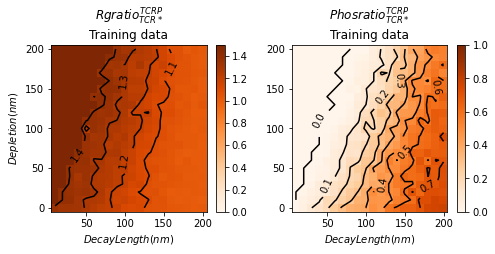

In [6]:
DataToPlot[0] = [[decayLength,depletion],[RgRatio,phosRatio]]
plotWhat=[True,False,False,False]

plotData(DataToPlot, plotWhat)

In [10]:
def linearlinear(xy, Intercept, xSlope, ySlope):
    x,y = xy
    f = Intercept + xSlope*x + ySlope*y
    strf = "Intercecpt + xSlope*x + ySlope*y"
    
    return f

In [11]:
#@title Read training data from csv file
# Reading data from csv file:
df_trainingData_model3 = pd.read_csv('trainingData_model3.csv')

# Rg_ratio,phos_ratio
# Reading data from DataFrame:
# 'f' is for 'flatten'  
fdecayLength = df_trainingData_model3['decayLength']
fdepletion = df_trainingData_model3['depletion']
fRgRatio = df_trainingData_model3['RgRatio']
fphosRatio = df_trainingData_model3['phosRatio']


In [12]:
#@title 2.2.2. Get fit parameters
def get_fit_parameters(X,fitFunc,fXdata,parametersNames,p0,bounds):
    """
    Returns fit parameters and aranges them in DataFrames where the index (rows)
    are the fit parameters' names and the columns are 'mu' and 'sd'.
    """
    popt, pcov = curve_fit(fitFunc, X, fXdata, p0, bounds) # (0, [3., 1., 0.5]
    mu = popt
    sd = np.sqrt(np.diag(pcov))

    data = {'mu':mu,'sd':sd}
    index = parametersNames
    
    df = pd.DataFrame(data,index=index)

    return df


In [13]:
#@title Fit parameters for pTCRrMean
p0_RgRatio = 1., 0., 0.
# bounds_Rg_ratio = ([-1.,-1., -1.],
#                     [2., 1., 1.]) 
parametersNames_RgRatio = ['Intercept', 'xSlope', 'ySlope'] # 

df_fitParameters_RgRatio = get_fit_parameters(X = (fdecayLength,fdepletion),
                              fitFunc = linearlinear, 
                              fXdata = fRgRatio,
                              parametersNames = parametersNames_RgRatio,
                              p0 = p0_RgRatio,
                              bounds = None)

df_fitParameters_RgRatio = df_fitParameters_RgRatio.round(3)
display(df_fitParameters_RgRatio)

,mu,sd
Intercept,1.466,0.005
xSlope,-0.003,0.000
ySlope,0.001,0.000


In [14]:
#@title Fit parameters for pTCRrMean
p0_phosRatio = 1., 0., 0.
# bounds_Rg_ratio = ([-1.,-1., -1.],
#                     [2., 1., 1.]) 
parametersNames_phosRatio = ['Intercept', 'xSlope', 'ySlope'] # 

df_fitParameters_phosRatio = get_fit_parameters(X = (fdecayLength,fdepletion),
                              fitFunc = linearlinear, 
                              fXdata = fphosRatio,
                              parametersNames = parametersNames_phosRatio,
                              p0 = p0_RgRatio,
                              bounds = None)

df_fitParameters_phosRatio = df_fitParameters_phosRatio.round(3)
display(df_fitParameters_phosRatio)

,mu,sd
Intercept,-0.016,0.009
xSlope,0.004,0.000
ySlope,-0.001,0.000


In [15]:
xy = decayLength_array, depletion_array
Intercept_fit = df_fitParameters_RgRatio.loc['Intercept','mu']
xSlope_fit = df_fitParameters_RgRatio.loc['xSlope','mu']
ySlope_fit = df_fitParameters_RgRatio.loc['ySlope','mu']

RgRatio_fit = linearlinear(xy, Intercept_fit, xSlope_fit, ySlope_fit)

In [16]:
xy = decayLength_array, depletion_array
Intercept_fit = df_fitParameters_phosRatio.loc['Intercept','mu']
xSlope_fit = df_fitParameters_phosRatio.loc['xSlope','mu']
ySlope_fit = df_fitParameters_phosRatio.loc['ySlope','mu']

phosRatio_fit = linearlinear(xy, Intercept_fit, xSlope_fit, ySlope_fit)

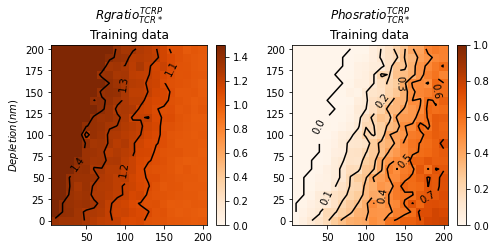

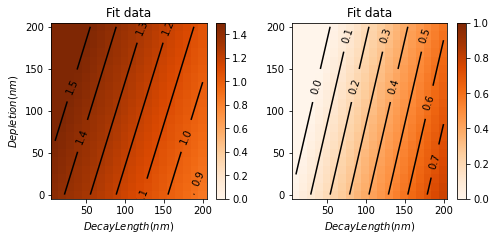

In [17]:
DataToPlot[1] = [[decayLength,depletion],[RgRatio_fit,phosRatio_fit]]
plotWhat=[True,True,False,False]

plotData(DataToPlot, plotWhat)

In [18]:
#@title Class RV new
class RV: # TODO for Barak - make CSV field names correspond to dictionary names or have a meta-dict for it
    def __init__(self,
                 id : str,
                 type2 : str,
                 shortName : str,
                 texName : str,
                 description : str,
                 distribution : str,
                 distributionParameters : dict,
                 units : str):
        
        self.id = id # str
        self.type2 = type2 # str
        self.shortName = shortName # str
        self.texName = texName # str
        self.description = description # str
        self.distribution = distribution # str
        self.distributionParameters = distributionParameters # array
        self.units = units # str


    def get_as_dictionary(self):  
        return {'ID': self.id, # Unique variable name that is used by pymc3, e.g. rv_tSlope_wTCR_KSEG1.
                'Type': self.type2, # Type of variable, e.g. 'Free parameter', 'Random variable'
                'Short Name': self.shortName, # Short name, e.g. 't'.
                'Latex Name': self.texName, # LaTex name for display.
                'Description': self.description, # 
                'Distribution': self.distribution,
                'Distribution parameters': self.distributionParameters,
                'Units': self.units}   

    def get_pymc3_statement():
        '''
        TASK 1
        TODO make this return a 2-tuple from a variable name 
        to a pymc3 statment for creating this random variable
        (to be used as input for eval)
        '''
#         if RV.distribution == "Normal":
#             mu = RV.distributionParameters["mu"]
#             sd = RV.distributionParameters["sd"]
#             s0 = RV.id
#             if RV.shortName == "output":
#                 print(RV.shortName)
#             s1 = ("pm." + RV.distribution + "('" + RV.id  + "'" + \
#                                       ", mu=" + str(mu) + \
#                                       ", sd=" + str(sd) + ")")
#             s = (s0,s1)
#             print(eval("s[0]"),"=",eval("s[1]"))
        '''
        Example: return tuple :
        s = ('rv_alpha', 'pm.Normal("rv_alpha", mu=354, sigma=a*10+b*20)')
        so we can do eval(s[0]) = eval(s[1])
        '''
      # TODO: WRITE-ME
#       return

    @staticmethod
    def RV_from_dictionary(d : dict):
        ''' generates an RV object from a dictionary produced by get_as_dictionary() '''  
        return RV(id=d['ID'],
                type2=d['Type'],
                shortName=d['Short Name'],
                texName=d['Latex Name'],
                description=d['Description'],
                distribution=d['Distribution'],
                distributionParameters=d['Distribution parameters'],
                units=d['Units'])


In [19]:
#@title Class model
model1_description = """Distributions and inter distances of TCR and CD45 molecules
that result from the early contact of a T cell and APC (Antigen Presenting Cell)."""

class Model:
    # Constructor
    def __init__(self, 
                 shortName : str, 
                 longName : str, 
                 description : str, 
                 model_id  : str,
                 RV_csv_file = None, # Topology of Bayes net
                 data_csv_file = None): # Training data
        '''
        '''
        self.shortName = shortName # str
        self.longName = longName # str
        self.description = description # str
        self.model_id = model_id # str
        self.set_RVs_from_csv(RV_csv_file) # fill in random variables from CSV file
        self.set_data_from_csv(data_csv_file) # fill in training data from CSV file

    # add a random variable to the model
    def add_rv(self, rv): # BARAK
        self.RVs.append(rv)

    def get_dataframe(self): # TODO: think about the name
        info = [ rv.get_as_dictionary() for rv in self.RVs ]
        df = pd.DataFrame(info)
        df.set_index('ID', drop=False)  
        return df

    def to_csv(self, csv_file): # TODO: think about the name
        df = self.get_dataframe()
        df.to_csv(csv_file)

    def set_RVs_from_csv(self, csv_file):
        ''' 
        read csv file (similar to Table S1 in metamodeling paper) with random variables
        and set this model's random variables and the statistical relations among them
        accordingly

        If csv_file is None, set an empty list of RVs
        '''
        self.RVs = []
        if csv_file == None:
            return
        df = pd.read_csv(csv_file)
        # TODO: assert that it has all the right fields
        rv_dicts = df.to_dict('records') # TODO: check if this is still appropraite
        print("RV dicts from csv:")
        print(rv_dicts)
        for rv_dict in rv_dicts:
            rv= RV.from_dictionary(rv_dict)
            self.add_rv(rv)

    def set_data_from_csv(self, data_csv_file):
    # TASK 2
        # df = pd.read_csv(data_csv_file)
        # display(df) # Yair
        # TODO: code for filling in table of data
        # self.data = ... # WRITE-ME
        self.trainingData = pd.read_csv(data_csv_file)

    # generate a pymc3 model from this model
    def get_as_pymc3(self): # BARAK
    # TASK 3 - make sure this works
        '''
        Go over all random variables in this model, 
        and generate a PyMC3 object with cooresponding
        variable names and statistical relations among them
        '''
        # TODO (use "eval" command)
        pm_model = pm.Model()
        with pm_model as pm:
             for rv in self.RVs:
                 pass
            #    s = rv.get_pymc3_statement()
            #    eval(s[0]) = eval(s[1])
        return pm_model

    def update_rvs_from_pymc3(self, pymc3): # BARAK
    # TASK 4 
        # TODO: use trace from trained PyMC3 model to update statements for all RVs
        return

    
     

In [65]:
#@title Start model3_rMean
model3_RgRatio = Model(shortName = 'TCRP',  # str
               longName = 'TCR phosphorylation', # str
               description = 'Model3 description', # str
               model_id = '3', #, # str
               RV_csv_file = None,
               data_csv_file = 'trainingData_model3.csv') 


In [66]:
#@title Start model3_hMean
model3_phosRatio = Model(shortName = 'TCRP',  # str
               longName = 'TCR phosphorylation', # str
               description = 'Model3 description', # str
               model_id = '3', #, # str
               RV_csv_file = None,
               data_csv_file = 'trainingData_model3.csv') 


In [67]:
#@title Define RgRatio untrained table
# for RV in (model3_RgRatio.RVs):
    
# Free parameters (fp):
model3_RgRatio.add_rv(
    RV(id = 'fp_DL_TCRP3',
       type2 = 'Free parameter',
       shortName = 'decaylength',
       texName = "$$DecayLength^{TCRP}$$",
       description = 'DecayLength(nm)',
       distribution = 'Normal',
       distributionParameters = {'mu': str(100.), 'sd': str(50.)},
       units = '$$nm$$'))

model3_RgRatio.add_rv(
    RV(id = 'fp_dep_TCRP3',
        type2 = 'Free parameter',
        shortName = 'depletion',
        texName = '$$Depletion^{TCRP}$$',
        description = 'Depletion distance between TCR and CD45',
        distribution = 'Normal',
        distributionParameters = {'mu': str(100.), 'sd': str(50.)},
        units = '$$nm$$'))

# Random variables (rv):
model3_RgRatio.add_rv(
    RV(id = 'rv_Intercept_RgRatio_TCRP3',
        type2 = 'Random variable',
        shortName = 'Intercept',
        texName = '$$RgRatio^{TCRP}_{Intercept}$$',
        description = 'Interception with Z axis',
        distribution = 'Normal',
        distributionParameters = {'mu': str(df_fitParameters_RgRatio.loc['Intercept','mu']), # TODO: get from table 
                                  'sd': str(0.5)}, #df_fitParameters_pTCRrMean.loc['min','sd']
        units = '$$-$$')) 

model3_RgRatio.add_rv(
    RV(id = 'rv_xSlope_RgRatio_TCRP3',
        type2 = 'Random variable',
        shortName = 'xSlope',
        texName = '$$RgRatio^{TCRP}_{xSlope}$$',
        description = 'Slope in x direction',
        distribution = 'Normal',
        distributionParameters = {'mu': str(df_fitParameters_RgRatio.loc['xSlope','mu']), # TODO: get from table 
                                  'sd': str(0.1)},  # df_fitParameters_RgRatio.loc['xSlope','sd']
        units = '$$-$$')) 

model3_RgRatio.add_rv(
    RV(id = 'rv_ySlope_RgRatio_TCRP3',
        type2 = 'Random variable',
        shortName = 'ySlope',
        texName = '$$RgRatio^{TCRP}_{ySlope}$$',
        description = 'Slope in y direction',
        distribution = 'Normal',
        distributionParameters = {'mu': str(df_fitParameters_RgRatio.loc['ySlope','mu']), # TODO: get from table 
                                  'sd': str(0.1)},  # df_fitParameters_RgRatio.loc['ySlope','sd']
        units = '$$-$$')) 

model3_RgRatio.add_rv(
    RV(id = 'rv_output_RgRatio_TCRP3',
       type2 = 'Random variable',
       shortName = 'output',
       texName = '$$RgRatio^{TCRP}_{output}$$',
       description = 'RgRatio output',
       distribution = 'Normal',
       distributionParameters = {'mu': str(1.), 'sd': str(0.1)},
       units = "$$nm$$")) 

model3_RgRatio.to_csv("model3_RgRatio.csv")

In [68]:
#@title Define phosRatio untrained table
# for RV in (model3_phosRatio.RVs):
    
# Free parameters (fp):
model3_phosRatio.add_rv(
    RV(id = 'fp_DL_TCRP3',
       type2 = 'Free parameter',
       shortName = 'decaylength',
       texName = "$$DecayLength^{TCRP}$$",
       description = 'DecayLength(nm)',
       distribution = 'Normal',
       distributionParameters = {'mu': str(100.), 'sd' : str(50.)},
       units = '$$nm$$'))

model3_phosRatio.add_rv(
    RV(id = 'fp_dep_TCRP3',
        type2 = 'Free parameter',
        shortName = 'depletion',
        texName = '$$Depletion^{TCRP}$$',
        description = 'Depletion distance between TCR and CD45',
        distribution = 'Normal',
        distributionParameters = {'mu': str(100.), 'sd' : str(50.)},
        units = '$$nm$$'))

# Random variables (rv):
model3_phosRatio.add_rv(
    RV(id = 'rv_Intercept_phosRatio_TCRP3',
        type2 = 'Random variable',
        shortName = 'Intercept',
        texName = '$$phosRatio^{TCRP}_{Intercept}$$',
        description = 'Interception with Z axis',
        distribution = 'Normal',
        distributionParameters = {'mu': str(df_fitParameters_phosRatio.loc['Intercept','mu']), # TODO: get from table 
                                  'sd': str(0.5)}, #df_fitParameters_phosRatio.loc['min','sd']
        units = '$$-$$')) 

model3_phosRatio.add_rv(
    RV(id = 'rv_xSlope_phosRatio_TCRP3',
        type2 = 'Random variable',
        shortName = 'xSlope',
        texName = '$$phosRatio^{TCRP}_{xSlope}$$',
        description = 'Slope in x direction',
        distribution = 'Normal',
        distributionParameters = {'mu': str(df_fitParameters_phosRatio.loc['xSlope','mu']), # TODO: get from table 
                                  'sd': str(0.5)},  # df_fitParameters_phosRatio.loc['xSlope','sd']
        units = '$$-$$')) 

model3_phosRatio.add_rv(
    RV(id = 'rv_ySlope_phosRatio_TCRP3',
        type2 = 'Random variable',
        shortName = 'ySlope',
        texName = '$$phosRatio^{TCRP}_{ySlope}$$',
        description = 'Slope in y direction',
        distribution = 'Normal',
        distributionParameters = {'mu': str(df_fitParameters_phosRatio.loc['ySlope','mu']), # TODO: get from table 
                                  'sd': str(0.5)},  # df_fitParameters_phosRatio.loc['ySlope','sd']
        units = '$$-$$')) 

model3_phosRatio.add_rv(
    RV(id = 'rv_output_phosRatio_TCRP3',
       type2 = 'Random variable',
       shortName = 'output',
       texName = '$$phosRatio^{TCRP}_{output}$$',
       description = 'phosRatio output',
       distribution = 'Normal',
       distributionParameters = {'mu': str(1.), 'sd': str(0.1)},
       units = "$$nm$$")) 

model3_phosRatio.to_csv("model3_phosRatio.csv")

In [69]:
df_model3_RgRatio_untrainedTable = model3_RgRatio.get_dataframe()
df_model3_RgRatio_untrainedTable = df_model3_RgRatio_untrainedTable.set_index('ID')

display(df_model3_RgRatio_untrainedTable.style.set_properties(**{
    'text-align': 'left',
    'background-color': 'rgba(255, 150, 0, 0.25)',
    'border': '1px black solid'}))

# display(df_model3_RgRatio_untrainedTable)

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_DL_TCRP3,Free parameter,decaylength,$$DecayLength^{TCRP}$$,DecayLength(nm),Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
fp_dep_TCRP3,Free parameter,depletion,$$Depletion^{TCRP}$$,Depletion distance between TCR and CD45,Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
rv_Intercept_RgRatio_TCRP3,Random variable,Intercept,$$RgRatio^{TCRP}_{Intercept}$$,Interception with Z axis,Normal,"{'mu': '1.466', 'sd': '0.5'}",$$-$$
rv_xSlope_RgRatio_TCRP3,Random variable,xSlope,$$RgRatio^{TCRP}_{xSlope}$$,Slope in x direction,Normal,"{'mu': '-0.003', 'sd': '0.1'}",$$-$$
rv_ySlope_RgRatio_TCRP3,Random variable,ySlope,$$RgRatio^{TCRP}_{ySlope}$$,Slope in y direction,Normal,"{'mu': '0.001', 'sd': '0.1'}",$$-$$
rv_output_RgRatio_TCRP3,Random variable,output,$$RgRatio^{TCRP}_{output}$$,RgRatio output,Normal,"{'mu': '1.0', 'sd': '0.1'}",$$nm$$


In [70]:
df_model3_phosRatio_untrainedTable = model3_phosRatio.get_dataframe()
df_model3_phosRatio_untrainedTable = df_model3_phosRatio_untrainedTable.set_index('ID')

display(df_model3_phosRatio_untrainedTable.style.set_properties(**{
    'text-align': 'left',
    'background-color': 'rgba(255, 150, 0, 0.50)',
    'border' : '1px black solid'}))

# display(df_model3_phosRatio_untrainedTable)

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_DL_TCRP3,Free parameter,decaylength,$$DecayLength^{TCRP}$$,DecayLength(nm),Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
fp_dep_TCRP3,Free parameter,depletion,$$Depletion^{TCRP}$$,Depletion distance between TCR and CD45,Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
rv_Intercept_phosRatio_TCRP3,Random variable,Intercept,$$phosRatio^{TCRP}_{Intercept}$$,Interception with Z axis,Normal,"{'mu': '-0.016', 'sd': '0.5'}",$$-$$
rv_xSlope_phosRatio_TCRP3,Random variable,xSlope,$$phosRatio^{TCRP}_{xSlope}$$,Slope in x direction,Normal,"{'mu': '0.004', 'sd': '0.5'}",$$-$$
rv_ySlope_phosRatio_TCRP3,Random variable,ySlope,$$phosRatio^{TCRP}_{ySlope}$$,Slope in y direction,Normal,"{'mu': '-0.001', 'sd': '0.5'}",$$-$$
rv_output_phosRatio_TCRP3,Random variable,output,$$phosRatio^{TCRP}_{output}$$,phosRatio output,Normal,"{'mu': '1.0', 'sd': '0.1'}",$$nm$$


In [71]:
# df_model3_untrainedTable = pd.concat([df_model3_RgRatio_untrainedTable,
#                                       df_model3_phosRatio_untrainedTable], ignore_index=False)

df_model3_untrainedTable = pd.concat([df_model3_RgRatio_untrainedTable,
                                      df_model3_phosRatio_untrainedTable.iloc[2:,:]], ignore_index=False)
# display(df_model3_untrainedTable.style.set_properties(**{'text-align': 'left',
#                                                 'background-color': 'rgba(255, 150, 0, 0.25)',
#                                                 'border' : '1px black solid'}))


display(df_model3_untrainedTable)

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_DL_TCRP3,Free parameter,decaylength,$$DecayLength^{TCRP}$$,DecayLength(nm),Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
fp_dep_TCRP3,Free parameter,depletion,$$Depletion^{TCRP}$$,Depletion distance between TCR and CD45,Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
rv_Intercept_RgRatio_TCRP3,Random variable,Intercept,$$RgRatio^{TCRP}_{Intercept}$$,Interception with Z axis,Normal,"{'mu': '1.466', 'sd': '0.5'}",$$-$$
rv_xSlope_RgRatio_TCRP3,Random variable,xSlope,$$RgRatio^{TCRP}_{xSlope}$$,Slope in x direction,Normal,"{'mu': '-0.003', 'sd': '0.1'}",$$-$$
rv_ySlope_RgRatio_TCRP3,Random variable,ySlope,$$RgRatio^{TCRP}_{ySlope}$$,Slope in y direction,Normal,"{'mu': '0.001', 'sd': '0.1'}",$$-$$
rv_output_RgRatio_TCRP3,Random variable,output,$$RgRatio^{TCRP}_{output}$$,RgRatio output,Normal,"{'mu': '1.0', 'sd': '0.1'}",$$nm$$
rv_Intercept_phosRatio_TCRP3,Random variable,Intercept,$$phosRatio^{TCRP}_{Intercept}$$,Interception with Z axis,Normal,"{'mu': '-0.016', 'sd': '0.5'}",$$-$$
rv_xSlope_phosRatio_TCRP3,Random variable,xSlope,$$phosRatio^{TCRP}_{xSlope}$$,Slope in x direction,Normal,"{'mu': '0.004', 'sd': '0.5'}",$$-$$
rv_ySlope_phosRatio_TCRP3,Random variable,ySlope,$$phosRatio^{TCRP}_{ySlope}$$,Slope in y direction,Normal,"{'mu': '-0.001', 'sd': '0.5'}",$$-$$


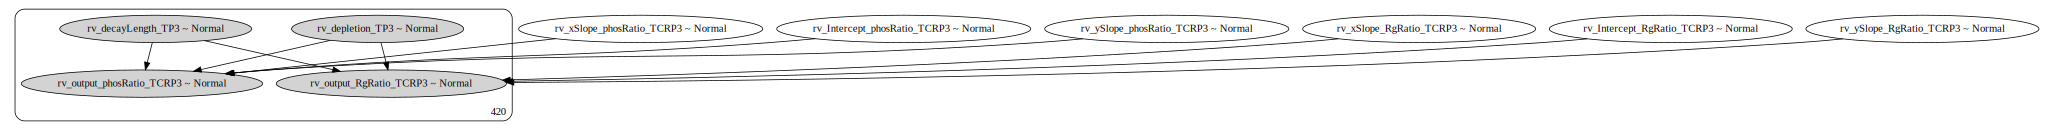

In [73]:
#@title Untrained model

def get_pm_model3_untrained(df_trainingData_model3):  
    
    pm_model3 = pm.Model()
    with pm_model3:
        dfRV = df_model3_untrainedTable
        DP = 'Distribution parameters'
        ### model3 - TCRP (TCR phosphorylation) #######################        
        # model3.D:
        decayLength_TCRP3_obs = df_trainingData_model3.loc[:,'decayLength'].values
        depletion_TCRP3_obs = df_trainingData_model3.loc[:,'depletion'].values

        # random variables x and y
        rv_decayLength_TCRP3 = pm.Normal('rv_decayLength_TP3', 100., 50., observed=decayLength_TCRP3_obs)
        rv_depletion_TCRP3 = pm.Normal('rv_depletion_TP3', 100., 50., observed=depletion_TCRP3_obs) 
        
        # observed:
        RgRatio_obs = df_trainingData_model3.loc[:,'RgRatio'].values
        phosRatio_obs = df_trainingData_model3.loc[:,'phosRatio'].values
        
        # rMean_TCRP3 ####################################################
        # read parameters values from RV table:
        
        # rv_Intercept_RgRatio_TCRP3:
        ID = 'rv_Intercept_RgRatio_TCRP3'
        rv_Intercept_RgRatio_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))

        # rv_xSlope_RgRatio_TCRP3:
        ID = 'rv_xSlope_RgRatio_TCRP3'
        rv_xSlope_RgRatio_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_ySlope_RgRatio_TCRP3:
        ID = 'rv_ySlope_RgRatio_TCRP3'
        rv_ySlope_RgRatio_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))
        
        # rv_output_RgRatio_TCRP3:
        ID = 'rv_output_RgRatio_TCRP3'
        rv_output_RgRatio_TCRP3 = pm.Normal(ID, 
            mu = rv_Intercept_RgRatio_TCRP3 + \
                rv_xSlope_RgRatio_TCRP3 * rv_decayLength_TCRP3 + \
                rv_ySlope_RgRatio_TCRP3 * rv_depletion_TCRP3,
            sd = eval(dfRV.loc[ID,DP]['sd']),
            observed = RgRatio_obs)
        
        # phosRatio_TCRP ####################
        # Read parameters values from RV table:
        
        # rv_Intercept_phosRatio_TCRP3
        ID = 'rv_Intercept_phosRatio_TCRP3'
        rv_Intercept_phosRatio_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))

        # rv_xSlope_phosRatio_TCRP3
        ID = 'rv_xSlope_phosRatio_TCRP3'
        rv_xSlope_phosRatio_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_ySlope_phosRatio_TCRP3
        ID = 'rv_ySlope_phosRatio_TCRP3'
        rv_ySlope_phosRatio_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))

        # rv_output_phosRatio_TCRP3:
        ID = 'rv_output_phosRatio_TCRP3'
        rv_output_phosRatio_TCRP3 = pm.Normal(ID, 
            mu = rv_Intercept_phosRatio_TCRP3 + \
                rv_xSlope_phosRatio_TCRP3 * rv_decayLength_TCRP3 + \
                rv_ySlope_phosRatio_TCRP3 * rv_depletion_TCRP3,
            sd = eval(dfRV.loc[ID,DP]['sd']),
            observed = phosRatio_obs)
        
        #############################################################
    return pm_model3

pm_model3 = get_pm_model3_untrained(df_trainingData_model3) 
gv3 = pm.model_to_graphviz(pm_model3)
gv3  

In [74]:
with pm_model3:
    trace3 = pm.sample(2000, chains=4);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rv_ySlope_phosRatio_TCRP3, rv_xSlope_phosRatio_TCRP3, rv_Intercept_phosRatio_TCRP3, rv_ySlope_RgRatio_TCRP3, rv_xSlope_RgRatio_TCRP3, rv_Intercept_RgRatio_TCRP3]
Sampling 4 chains, 183 divergences: 100%|██████████| 10000/10000 [06:02<00:00, 27.56draws/s]
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9850233075867747, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9985470334195454, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not mat

C:\Users\Owner\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


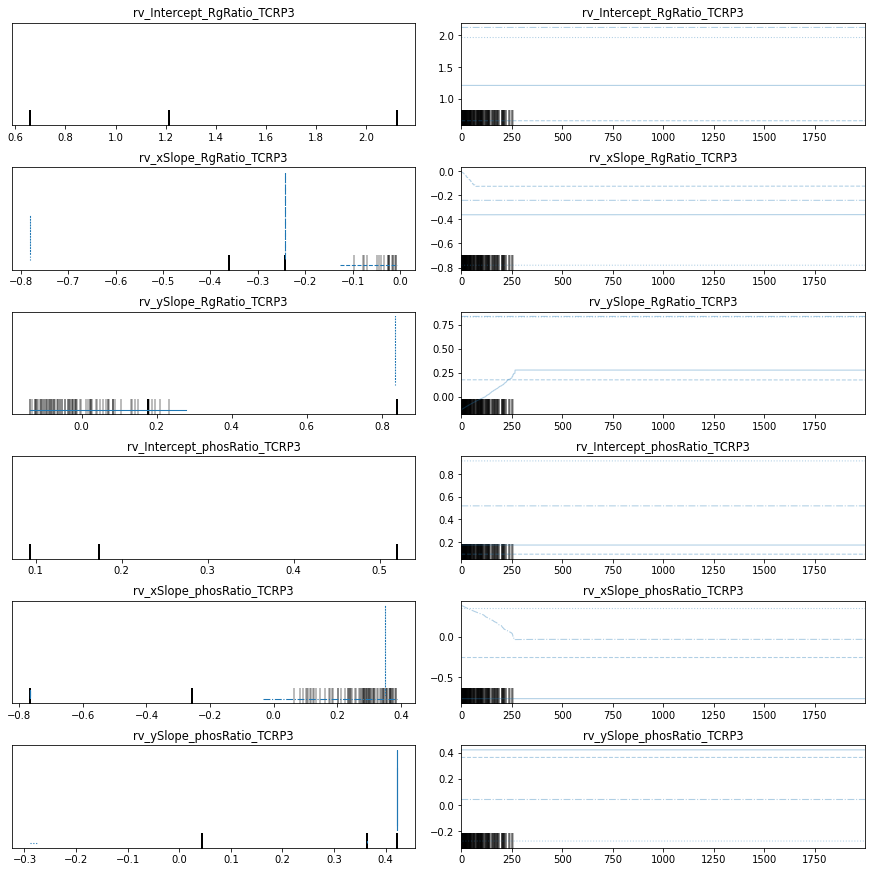

In [75]:
pm.traceplot(trace3);

In [76]:
#@title Save trace

trace3_summary = pm.summary(trace3) #.round(3) # var_names=["mu", "tau"]
trace3_summary.to_pickle('trace3_summary')
# if True: # True: # False
#     files.download("trace3_summary") 
# !ls

C:\Users\Owner\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [77]:
#@title Read 'mean' and 'sd' values from 'trace_summary'
# r = read, to distinguish between the original and the saved files.
trace3_summary_r = pd.read_pickle('trace3_summary') 

# displaying the rv names and the data of intersest: 'mean' and 'sd':
mean_sd_r = trace3_summary_r.loc[:, ['mean','sd']]
mean_sd_r

,mean,sd
rv_Intercept_RgRatio_TCRP3,1.491,0.592
rv_xSlope_RgRatio_TCRP3,-0.377,0.248
rv_ySlope_RgRatio_TCRP3,0.524,0.318
rv_Intercept_phosRatio_TCRP3,0.426,0.326
rv_xSlope_phosRatio_TCRP3,-0.168,0.409
rv_ySlope_phosRatio_TCRP3,0.139,0.278


In [84]:
#@ Update trained parameters values
df_model3_trainedTable = df_model3_untrainedTable
DP = 'Distribution parameters'
for rv in mean_sd_r.index:
#     print(rv)
    df_model3_trainedTable.loc[rv,DP]['mu'] = str(mean_sd_r.loc[rv]['mean'])
    df_model3_trainedTable.loc[rv,DP]['sd'] = str(mean_sd_r.loc[rv]['sd'])
    
df_model3_trainedTable.to_pickle('df_model3_trainedTable')

# display(df_model3_trainedTable.style.set_properties(**{'text-align': 'left',
#                                                 'background-color': 'rgba(255, 150, 0, 0.5)',
#                                                 'border' : '1px black solid',
#                                                 'width': '50px'}))
display(df_model3_trainedTable)

,Type,Short Name,Latex Name,Description,Distribution,Distribution parameters,Units
ID,,,,,,,
fp_DL_TCRP3,Free parameter,decaylength,$$DecayLength^{TCRP}$$,DecayLength(nm),Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
fp_dep_TCRP3,Free parameter,depletion,$$Depletion^{TCRP}$$,Depletion distance between TCR and CD45,Normal,"{'mu': '100.0', 'sd': '50.0'}",$$nm$$
rv_Intercept_RgRatio_TCRP3,Random variable,Intercept,$$RgRatio^{TCRP}_{Intercept}$$,Interception with Z axis,Normal,"{'mu': '1.491', 'sd': '0.592'}",$$-$$
rv_xSlope_RgRatio_TCRP3,Random variable,xSlope,$$RgRatio^{TCRP}_{xSlope}$$,Slope in x direction,Normal,"{'mu': '-0.377', 'sd': '0.248'}",$$-$$
rv_ySlope_RgRatio_TCRP3,Random variable,ySlope,$$RgRatio^{TCRP}_{ySlope}$$,Slope in y direction,Normal,"{'mu': '0.524', 'sd': '0.318'}",$$-$$
rv_output_RgRatio_TCRP3,Random variable,output,$$RgRatio^{TCRP}_{output}$$,RgRatio output,Normal,"{'mu': '1.0', 'sd': '0.1'}",$$nm$$
rv_Intercept_phosRatio_TCRP3,Random variable,Intercept,$$phosRatio^{TCRP}_{Intercept}$$,Interception with Z axis,Normal,"{'mu': '0.426', 'sd': '0.326'}",$$-$$
rv_xSlope_phosRatio_TCRP3,Random variable,xSlope,$$phosRatio^{TCRP}_{xSlope}$$,Slope in x direction,Normal,"{'mu': '-0.168', 'sd': '0.409'}",$$-$$
rv_ySlope_phosRatio_TCRP3,Random variable,ySlope,$$phosRatio^{TCRP}_{ySlope}$$,Slope in y direction,Normal,"{'mu': '0.139', 'sd': '0.278'}",$$-$$


In [83]:
DP = 'Distribution parameters'
# RgRatio
tr_Intercept_RgRatio_TCRP3 = eval(df_model3_trainedTable.loc['rv_Intercept_RgRatio_TCRP3',DP]['mu'])
tr_xSlope_RgRatio_TCRP3 = eval(df_model3_trainedTable.loc['rv_xSlope_RgRatio_TCRP3',DP]['mu'])
tr_ySlope_RgRatio_TCRP3 = eval(df_model3_trainedTable.loc['rv_ySlope_RgRatio_TCRP3',DP]['mu'])

RgRatio_trained = tr_Intercept_RgRatio_TCRP3 + \
    tr_xSlope_RgRatio_TCRP3 * decayLength_array + \
    tr_ySlope_RgRatio_TCRP3 * depletion_array

# phosRatio
tr_Intercept_phosRatio_TCRP3 = eval(df_model3_trainedTable.loc['rv_Intercept_phosRatio_TCRP3',DP]['mu'])
tr_xSlope_phosRatio_TCRP3 = eval(df_model3_trainedTable.loc['rv_xSlope_phosRatio_TCRP3',DP]['mu'])
tr_ySlope_phosRatio_TCRP3 = eval(df_model3_trainedTable.loc['rv_ySlope_phosRatio_TCRP3',DP]['mu'])

phosRatio_trained = tr_Intercept_phosRatio_TCRP3 + \
    tr_xSlope_phosRatio_TCRP3 * decayLength_array + \
    tr_ySlope_phosRatio_TCRP3 * depletion_array


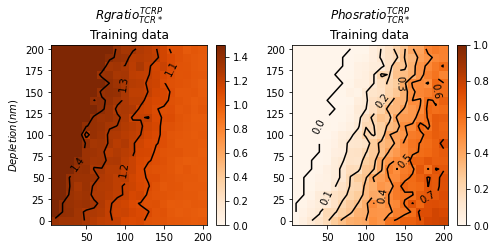

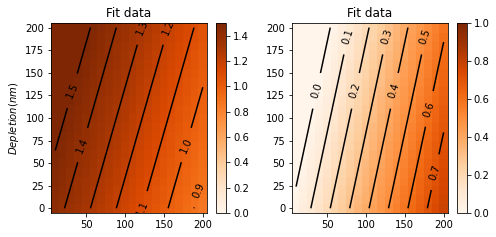

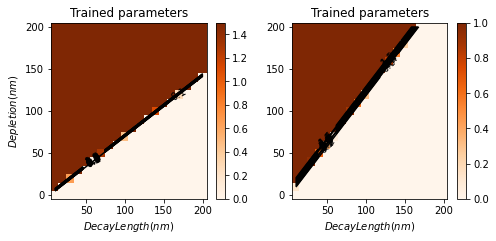

In [81]:
DataToPlot[2] = [[decayLength,depletion],[RgRatio_trained,phosRatio_trained]]
plotWhat=[True,True,True,False]

plotData(DataToPlot, plotWhat)

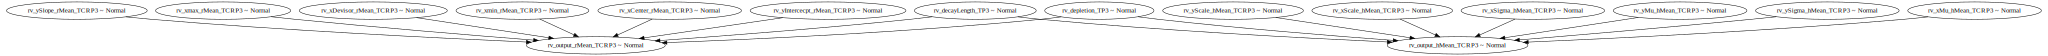

In [41]:
#@title Build trained model (with updated parameter estimates through their posteriors)
### model3 - TP (TCR phosphorylation) ##############################
def get_pm_model3_trained(trace3, decayLength_obs=None, depletion_obs=None):
    ''' return model3 trained based on trace3. 
    If observed_decayLength and/or observed_depletion are specified, 
    return the model conditioned on those values '''

    pm_model3_trained = pm.Model()
    with pm_model3_trained:
        dfRV = df_model3_trainedTable
        DP = 'Distribution parameters'

        # random variables x and y
        rv_decayLength_TCRP3 = pm.Normal('rv_decayLength_TP3', 100., 50., observed=decayLength_obs)
        rv_depletion_TCRP3 = pm.Normal('rv_depletion_TP3', 100., 50., observed=depletion_obs) 

        # rMean_TCRP3 ####################################################
        """TODO: read parameters values from RV table"""
        # rv_xmin_rMean_TCRP3
        ID = 'rv_xmin_rMean_TCRP3'
        rv_xmin_rMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd']))

        # rv_xmax_rMean_TCRP3
        ID = 'rv_xmax_rMean_TCRP3'
        rv_xmax_rMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_xCenter_rMean_TCRP3
        ID = 'rv_xCenter_rMean_TCRP3'
        rv_xCenter_rMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_xDevisor_rMean_TCRP3
        ID = 'rv_xDevisor_rMean_TCRP3'
        rv_xDevisor_rMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_yIntercecpt_rMean_TCRP3
        ID = 'rv_yIntercecpt_rMean_TCRP3'
        rv_yIntercecpt_rMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_ySlope_rMean_TCRP3
        ID = 'rv_ySlope_rMean_TCRP3'
        rv_ySlope_rMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_output_rMean_TCRP3, equation:
        ID = 'rv_output_rMean_TCRP3'
        rv_output_rMean_TCRP3 = pm.Normal(ID, 
            mu = rv_xmin_rMean_TCRP3 +\
            (rv_xmax_rMean_TCRP3 - rv_xmin_rMean_TCRP3)*\
            np.exp(-0.5*((rv_decayLength_TCRP3 - rv_xCenter_rMean_TCRP3)/rv_xDevisor_rMean_TCRP3)) +\
            rv_yIntercecpt_rMean_TCRP3 + rv_ySlope_rMean_TCRP3*rv_depletion_TCRP3,
            sd = eval(dfRV.loc[ID,DP]['sd'])) #

        #####################################
        # "xmin+(xmax-xmin)*np.exp(-0.5*((x-xCenter)/xDevisor)) + yIntercecpt + ySlope*y"
        #####################################
        
        # hMean_TCRP ####################################################Z
        """TODO: read parameters values from RV table"""
        # rv_xScale_hMean_TCRP3
        ID = 'rv_xScale_hMean_TCRP3'
        rv_xScale_hMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_xSigma_hMean_TCRP3
        ID = 'rv_xSigma_hMean_TCRP3'
        rv_xSigma_hMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_xMu_hMean_TCRP3
        ID = 'rv_xMu_hMean_TCRP3'
        rv_xMu_hMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_yScale_hMean_TCRP3
        ID = 'rv_yScale_hMean_TCRP3'
        rv_yScale_hMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_ySigma_hMean_TCRP3
        ID = 'rv_ySigma_hMean_TCRP3'
        rv_ySigma_hMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 

        # rv_yMu_hMean_TCRP3
        ID = 'rv_yMu_hMean_TCRP3'
        rv_yMu_hMean_TCRP3 = pm.Normal(ID, 
            mu = eval(dfRV.loc[ID,DP]['mu']), 
            sd = eval(dfRV.loc[ID,DP]['sd'])) 


        # rv_output_hMean_TCRP3, equation:
        ID = 'rv_output_hMean_TCRP3'
        rv_output_hMean_TCRP3 = pm.Normal(ID, 
            mu = rv_xScale_hMean_TCRP3*\
            np.exp(-0.5*((rv_decayLength_TCRP3 - rv_xMu_hMean_TCRP3)/rv_xSigma_hMean_TCRP3)**2) +\
            rv_yScale_hMean_TCRP3*\
            np.exp(-0.5*((rv_depletion_TCRP3 - rv_yMu_hMean_TCRP3)/rv_ySigma_hMean_TCRP3)**2),
            sd = eval(dfRV.loc[ID,DP]['sd'])) #
        
    return pm_model3_trained

pm_model3_trained= get_pm_model3_trained(trace3)

gv3 = pm.model_to_graphviz(pm_model3_trained)
gv3  

In [82]:
if True:
    n_depletions = 21 
    n_decayLengths = 20 
    deps = np.linspace(0, 200, n_depletions)
    decs = np.linspace(10, 200, n_decayLengths)

    RgRatios_mean = np.zeros((n_depletions, n_decayLengths))
    RgRatios_std = np.zeros((n_depletions, n_decayLengths))

    phosRatios_mean = np.zeros((n_depletions, n_decayLengths))
    phosRatios_std = np.zeros((n_depletions, n_decayLengths))

    for i,dep in enumerate(deps):
        for j,dec in enumerate(decs):
            #try:
            cur_model = get_pm_model3_trained(trace3, depletion_obs=dep, decayLength_obs=dec)
            with cur_model:
                cur_trace = pm.sample(2000, chains=4, progressbar = False);
            print(f"i,dep={i,dep}, j,lp={j,dec}")
            # display(pm.summary(cur_trace).round(3))
            pTCRrMeans_mean[i,j] = cur_trace.rv_output_rMean_TCRP3.mean() 
            pTCRrMeans_std[i,j] = cur_trace.rv_output_rMean_TCRP3.std()

            pTCRhMeans_mean[i,j] = cur_trace.rv_output_hMean_TCRP3.mean() 
            pTCRhMeans_std[i,j] = cur_trace.rv_output_hMean_TCRP3.std()
            #except ValueError:   


NameError: name 'get_pm_model3_trained' is not defined

In [43]:
if False:
    np.save("trained_pTCRrMean_TCRP_mean_26x25", pTCRrMeans_mean)
    np.save("trained_pTCRrMean_TCRP_std_26x25", pTCRrMeans_std)
    
    np.save("trained_pTCRhMean_TCRP_mean_26x25", pTCRhMeans_mean)
    np.save("trained_pTCRhMean_TCRP_std_26x25", pTCRhMeans_std)
    

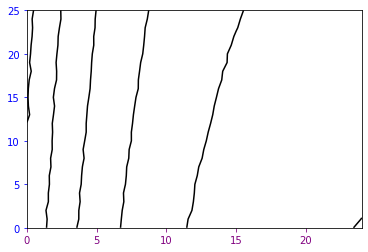

In [58]:
levels = np.linspace(125,250,6)
# contour([X, Y,] Z, [levels], **kwargs)
plt.contour(pTCRrMeans_mean, levels, colors='k')
plt.tick_params(axis='x', colors='purple')
plt.tick_params(axis='y', colors='blue')